# IA - Trabalho 4
Nome: Matheus dos Santos Moura <br />
Matrícula: 1911985BCC
Vídeo: https://youtu.be/yTXYaG9hn3U

Tempo de cada questão no vídeo:
- Q1 - 00:00:13
- Q2 - 00:27:45
- Q3 - 00:38:00
- Q4 - 01:09:10
- Q5 - 01:16:00

In [42]:
SEED_VALUE = 42

In [43]:
import pickle
from pprint import pprint
from typing import Dict, Tuple, Optional
import category_encoders as ce
import numpy as np
import pandas as pd
import shap
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

## 1 - Predição de pagamento de empréstimos

### Obtendo dataframes de treino e teste

In [44]:
q1_column_names = [
    "ESCT",
    "NDEP",
    "RENDA",
    "TIPOR",
    "VBEM",
    "NPARC",
    "VPARC",
    "TEL",
    "IDADE",
    "RESMS",
    "ENTRADA",
    "CLASSE",
]
q1_df_train = pd.read_csv("../data/credtrain.txt", sep="\t", names=q1_column_names)
q1_df_test = pd.read_csv("../data/credtest.txt", sep="\t", names=q1_column_names)

### Codificando as features

In [46]:
q1_data_transformers = [
    (
        'Cat',
        OneHotEncoder(sparse_output=False,drop='first'),
        ['ESCT', 'TIPOR', 'TEL', 'CLASSE']
    ),
    (
        'Ord',
        OrdinalEncoder(categories=[[0, 1, 2, 3, 4, 5, 6, 7]]),
        ['NDEP']
    )
]
q1_column_transformer = ColumnTransformer(
     transformers=q1_data_transformers,
     remainder='passthrough',
     verbose_feature_names_out=False)
q1_column_transformer.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('Cat',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['ESCT', 'TIPOR', 'TEL', 'CLASSE']),
                                ('Ord',
                                 OrdinalEncoder(categories=[[0, 1, 2, 3, 4, 5,
                                                             6, 7]]),
                                 ['NDEP'])],
                  verbose_feature_names_out=False)

In [47]:
q1_transformed_df_train = q1_column_transformer.fit_transform(q1_df_train)
q1_transformed_df_test = q1_column_transformer.fit_transform(q1_df_test)

### Criando as matrizes de dados e classe

In [6]:
q1_X_train = q1_transformed_df_train.drop(['CLASSE_1'], axis = 1)
q1_y_train = q1_transformed_df_train.CLASSE_1.values

In [7]:
q1_X_test = q1_transformed_df_test.drop(['CLASSE_1'], axis = 1)
q1_y_test = q1_transformed_df_test.CLASSE_1.values

### Normalização dos dados

In [8]:
q1_scaler = MinMaxScaler()
q1_scaler.fit(q1_X_train)
q1_cols_backup = q1_X_train.columns
q1_X_train = pd.DataFrame(q1_scaler.transform(q1_X_train), columns=q1_cols_backup)
q1_X_test = q1_scaler.transform(q1_X_test)

In [9]:
q1_scaler.data_max_

array([1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 7.00e+00,
       8.00e+03, 4.00e+03, 2.40e+01, 7.11e+02, 7.00e+01, 4.20e+02,
       1.30e+03])

In [10]:
q1_X_train.describe()

,ESCT_1,ESCT_2,ESCT_3,TIPOR_1,TEL_1,NDEP,RENDA,VBEM,NPARC,VPARC,IDADE,RESMS,ENTRADA
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.400667,0.018667,0.024667,0.445333,0.134000,0.018095,0.088898,0.070819,0.321420,0.079043,0.435503,0.075068,0.024812
std,0.490197,0.135390,0.155159,0.497168,0.340766,0.081838,0.117602,0.071808,0.156919,0.095291,0.258868,0.125386,0.072544
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021753,0.029730,0.217391,0.024206,0.235294,0.014286,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.051351,0.391304,0.049924,0.392157,0.014286,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.116883,0.085946,0.391304,0.102874,0.647059,0.114286,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Avaliação dos modelos

In [49]:
def evaluate_model(
    model: BaseEstimator,
    x: pd.DataFrame,
    y: pd.Series,
    acc_train: Optional[float] = None,
) -> Tuple[Dict, Dict]:

    y_pred = model.predict(x)
    acc_train = acc_train * 100 if isinstance(acc_train, float) else None
    confusion_matrix = metrics.confusion_matrix(y, y_pred)
    result = {
            "accuracy_train": acc_train,
            "accuracy_test": metrics.accuracy_score(y, y_pred) * 100,
            "tp": confusion_matrix[0][0],
            "tn": confusion_matrix[0][1],
            "fp": confusion_matrix[1][0],
            "fn": confusion_matrix[1][1],
        }
    classification_report = metrics.classification_report(
        y, y_pred, output_dict=True
    )

    return result, classification_report

In [50]:
q1_models = [
    LogisticRegression(random_state=SEED_VALUE),
    DecisionTreeClassifier(random_state=SEED_VALUE),
    RandomForestClassifier(random_state=SEED_VALUE),
    KNeighborsClassifier(),
    GradientBoostingClassifier(random_state=SEED_VALUE),
]
q1_results = []
q1_classification_reports = {}

for model in q1_models:
    model.fit(q1_X_train, q1_y_train)
    result, classification_report = evaluate_model(
        model, q1_X_test, q1_y_test, model.score(q1_X_train, q1_y_train)
    )
    q1_results.append(result)
    q1_classification_reports[model.__class__.__name__] = classification_report

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names


In [51]:
pd.DataFrame(
    q1_results, index=[model.__class__.__name__ for model in q1_models]
)

,accuracy_train,accuracy_test,tp,tn,fp,fn
LogisticRegression,89.333333,89.081456,296,10,53,218
DecisionTreeClassifier,100.000000,85.268631,258,48,37,234
RandomForestClassifier,100.000000,89.428076,291,15,46,225
KNeighborsClassifier,90.666667,88.561525,291,15,51,220
GradientBoostingClassifier,93.533333,90.121317,296,10,47,224


In [53]:
pprint(q1_classification_reports['GradientBoostingClassifier'])

{'0.0': {'f1-score': 0.9121725731895225,
         'precision': 0.8629737609329446,
         'recall': 0.9673202614379085,
         'support': 306.0},
 '1.0': {'f1-score': 0.8871287128712871,
         'precision': 0.9572649572649573,
         'recall': 0.8265682656826568,
         'support': 271.0},
 'accuracy': 0.901213171577123,
 'macro avg': {'f1-score': 0.8996506430304048,
               'precision': 0.9101193590989509,
               'recall': 0.8969442635602827,
               'support': 577.0},
 'weighted avg': {'f1-score': 0.900410205518393,
                  'precision': 0.9072595741148779,
                  'recall': 0.901213171577123,
                  'support': 577.0}}


## 2 - Engenharia de Features

### Cast das columnas categóricas

In [54]:
q2_df_train = q1_df_train.copy()
q2_df_test = q1_df_test.copy()

columns_to_cast = ['ESCT', 'NDEP', 'TIPOR', 'TEL']

for column in columns_to_cast:
    q2_df_train[column] = q1_df_train[column].replace(to_replace={0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'})
    q2_df_test[column] = q1_df_test[column].replace(to_replace={0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'})

### Codificação de features usando a biblioteca Categories Encoders

In [55]:
q2_data_transformers = [
    (
        'glmm',
        ce.GLMMEncoder(),
        ['ESCT']
    ),
    (
        'woee',
        ce.WOEEncoder(drop_invariant=True),
        ['TIPOR', 'TEL', 'CLASSE']
    ),
    (
        'tget',
        ce.TargetEncoder(),
        ['NDEP']
    )
]
q2_column_transformer = ColumnTransformer(
     transformers=q2_data_transformers,
     remainder='passthrough',
     verbose_feature_names_out=False)
q2_column_transformer.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('glmm', GLMMEncoder(), ['ESCT']),
                                ('woee', WOEEncoder(drop_invariant=True),
                                 ['TIPOR', 'TEL', 'CLASSE']),
                                ('tget', TargetEncoder(), ['NDEP'])],
                  verbose_feature_names_out=False)

In [59]:
q2_transformed_df_train = q2_column_transformer.fit_transform(q2_df_train, q2_df_train['CLASSE'])
q2_transformed_df_test = q2_column_transformer.fit_transform(q2_df_test, q2_df_test['CLASSE'])

### Criando matrizes de treino e classe

In [60]:
q2_X_train = q2_transformed_df_train.drop(['CLASSE'], axis = 1)
q2_y_train = q2_transformed_df_train.CLASSE.values

q2_X_test = q2_transformed_df_test.drop(['CLASSE'], axis = 1)
q2_y_test = q2_transformed_df_test.CLASSE.values

### Normalização dos dados

In [61]:
scaler = MinMaxScaler()
scaler.fit(q2_X_train)
cols_backup = q2_X_train.columns
q2_X_train = pd.DataFrame(scaler.transform(q2_X_train), columns=cols_backup)
q2_X_test = scaler.transform(q2_X_test)

### Avaliação dos modelos

In [62]:
q2_results = []
q2_classification_reports = {}

for model in q1_models:
    model.fit(q2_X_train, q2_y_train)
    result, classification_report = evaluate_model(
        model, q2_X_test, q2_y_test, model.score(q2_X_train, q2_y_train)
    )
    q2_results.append(result)
    q2_classification_reports[model.__class__.__name__] = classification_report

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names


In [63]:
pd.DataFrame(
    q2_results, index=[model.__class__.__name__ for model in q1_models]
)

,accuracy_train,accuracy_test,tp,tn,fp,fn
LogisticRegression,89.533333,89.428076,297,9,52,219
DecisionTreeClassifier,100.000000,85.788562,258,48,34,237
RandomForestClassifier,100.000000,90.121317,297,9,48,223
KNeighborsClassifier,91.066667,88.388215,290,16,51,220
GradientBoostingClassifier,93.600000,90.467938,297,9,46,225


In [64]:
pprint(q2_classification_reports['GradientBoostingClassifier'])

{'0': {'f1-score': 0.9152542372881356,
       'precision': 0.8658892128279884,
       'recall': 0.9705882352941176,
       'support': 306.0},
 '1': {'f1-score': 0.891089108910891,
       'precision': 0.9615384615384616,
       'recall': 0.8302583025830258,
       'support': 271.0},
 'accuracy': 0.9046793760831889,
 'macro avg': {'f1-score': 0.9031716730995133,
               'precision': 0.913713837183225,
               'recall': 0.9004232689385717,
               'support': 577.0},
 'weighted avg': {'f1-score': 0.9039045842721333,
                  'precision': 0.9108128634355068,
                  'recall': 0.9046793760831889,
                  'support': 577.0}}


### 3- Conjuntos desbalanceados

### Obtendo conjunto de dados A652

In [118]:
file = open("../data/A652.pickle", "rb")
(q3_X_train, q3_y_train, q3_X_val, q3_y_val, q3_X_test, q3_y_test) = pickle.load(file)

In [119]:
print(f"Shapes : ", q3_X_train.shape , q3_X_val.shape , q3_X_test.shape)

Shapes :  (10012, 24) (2506, 24) (9582, 24)


### Binarizando matrizes de classe

In [120]:
binarizer = lambda arr: np.array([0 if x == 0 else 1 for x in arr])
q3_y_train = binarizer(q3_y_train)
q3_y_val = binarizer(q3_y_val)
q3_y_test = binarizer(q3_y_test)

### Pandarizando matrizes de dados e classe

In [121]:
q3_X_train = pd.DataFrame(q3_X_train)
q3_X_val = pd.DataFrame(q3_X_val)
q3_X_test = pd.DataFrame(q3_X_test)

q3_y_train = pd.Series(q3_y_train, name='y')
q3_y_val = pd.Series(q3_y_val, name='y')
q3_y_test = pd.Series(q3_y_test, name='y')

### Visualização do desbalanceamento dos dados

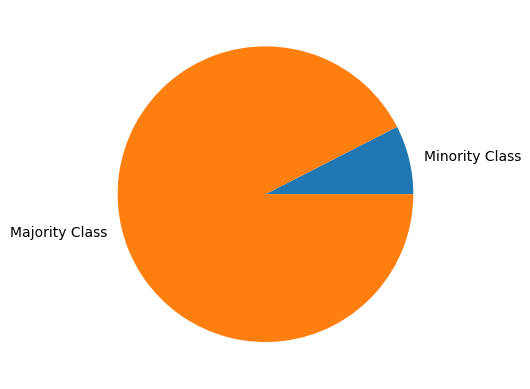

In [122]:
class_division = [np.count_nonzero(q3_y_train == 1), np.count_nonzero(q3_y_train == 0)]
my_labels = ['Minority Class', 'Majority Class']
plt.pie(class_division, labels = my_labels)
plt.show()

### Predições sem técnicas de balanceamento (justas)

In [113]:
gbc = GradientBoostingClassifier(random_state=SEED_VALUE)
q3_results = {}
q3_classification_reports = {}

gbc.fit(pd.concat([q3_X_train, q3_X_val]), pd.concat([q3_y_train, q3_y_val]))
q3_y_pred = gbc.predict(q3_X_test)
q3_confusion_matrix = metrics.confusion_matrix(q3_y_test, q3_y_pred)
q3_results['vanilla'] = {
    'accuracy_train': gbc.score(q3_X_train, q3_y_train) * 100,
    'accuracy_test': metrics.accuracy_score(q3_y_test, q3_y_pred) * 100,
    'tp': q3_confusion_matrix[0][0],
    'tn': q3_confusion_matrix[0][1],
    'fp': q3_confusion_matrix[1][0],
    'fn': q3_confusion_matrix[1][1]
}
q3_classification_reports['vanilla'] = metrics.classification_report(q3_y_test, q3_y_pred, output_dict=True)['1']

### Oversampling

In [114]:
q3_df_train = pd.concat([pd.concat([q3_X_train, q3_X_val]), pd.concat([q3_y_train, q3_y_val])], axis=1)
q3_y_zero=q3_df_train[q3_df_train.y==0]
q3_y_one=q3_df_train[q3_df_train.y==1]

upsampled_one = resample(q3_y_one,
                          replace=True, # sample with replacement
                          n_samples=len(q3_y_zero), # match number in majority class
                          random_state=SEED_VALUE)
upsampled = pd.concat([q3_y_zero, upsampled_one])


# gbc = GradientBoostingClassifier(random_state=SEED_NUMBER)
gbc.fit(upsampled.drop('y', axis=1), upsampled.y)
q3_y_pred = gbc.predict(q3_X_test)
q3_confusion_matrix = metrics.confusion_matrix(q3_y_test, q3_y_pred)
q3_results['oversample'] = {
    'accuracy_train': gbc.score(q3_X_train, q3_y_train) * 100,
    'accuracy_test': metrics.accuracy_score(q3_y_test, q3_y_pred) * 100,
    'tp': q3_confusion_matrix[0][0],
    'tn': q3_confusion_matrix[0][1],
    'fp': q3_confusion_matrix[1][0],
    'fn': q3_confusion_matrix[1][1]
}
q3_classification_reports['oversample'] = metrics.classification_report(q3_y_test, q3_y_pred, output_dict=True)['1']

### Undersampling

In [115]:
downsampled_zero = resample(q3_y_zero,
                          replace=False,
                          n_samples=len(q3_y_one),
                          random_state=SEED_VALUE)
downsampled = pd.concat([downsampled_zero, q3_y_one])


# gbc = GradientBoostingClassifier(random_state=SEED_NUMBER)
gbc.fit(downsampled.drop('y', axis=1), downsampled.y)
q3_y_pred = gbc.predict(q3_X_test)
q3_confusion_matrix = metrics.confusion_matrix(q3_y_test, q3_y_pred)
q3_results['undersample'] = {
    'accuracy_train': gbc.score(q3_X_train, q3_y_train) * 100,
    'accuracy_test': metrics.accuracy_score(q3_y_test, q3_y_pred) * 100,
    'tp': q3_confusion_matrix[0][0],
    'tn': q3_confusion_matrix[0][1],
    'fp': q3_confusion_matrix[1][0],
    'fn': q3_confusion_matrix[1][1]
}
q3_classification_reports['undersample'] = metrics.classification_report(q3_y_test, q3_y_pred, output_dict=True)['1']

### Ajuste de limiar

In [116]:
gbc.fit(q3_X_train, q3_y_train)
thresholds = [j/20 for j in range(1, 20)]
thresholds_results = {}

for i in thresholds:
    y_pred_new_threshold = (gbc.predict_proba(q3_X_val)[:,1]>=i).astype(int)
    f1_score_adj_threshold =  round((metrics.f1_score(q3_y_val, y_pred_new_threshold, average='binary')), 4)
    thresholds_results[i] = f1_score_adj_threshold

q3_y_pred = (gbc.predict_proba(q3_X_test)[:,1] >= max(thresholds_results.values())).astype(int)
q3_confusion_matrix = metrics.confusion_matrix(q3_y_test, q3_y_pred)
q3_results['limiar'] = {
    'accuracy_train': gbc.score(q3_X_train, q3_y_train) * 100,
    'accuracy_test': metrics.accuracy_score(q3_y_test, q3_y_pred) * 100,
    'tp': q3_confusion_matrix[0][0],
    'tn': q3_confusion_matrix[0][1],
    'fp': q3_confusion_matrix[1][0],
    'fn': q3_confusion_matrix[1][1]
}
q3_classification_reports['limiar'] = metrics.classification_report(q3_y_test, q3_y_pred, output_dict=True)['1']
pprint(thresholds_results)

{0.05: 0.4627,
 0.1: 0.6389,
 0.15: 0.6601,
 0.2: 0.6608,
 0.25: 0.6715,
 0.3: 0.6717,
 0.35: 0.6769,
 0.4: 0.6733,
 0.45: 0.668,
 0.5: 0.6539,
 0.55: 0.6288,
 0.6: 0.6236,
 0.65: 0.614,
 0.7: 0.5749,
 0.75: 0.5377,
 0.8: 0.4772,
 0.85: 0.3779,
 0.9: 0.2237,
 0.95: 0.0791}


### Q3 - Resultados

In [117]:
q3_results

{'vanilla': {'accuracy_train': 94.93101086211958,
  'accuracy_test': 92.32895646164478,
  'tp': 8723,
  'tn': 294,
  'fp': 483,
  'fn': 629},
 'oversample': {'accuracy_train': 91.78001761424797,
  'accuracy_test': 84.8751110672327,
  'tp': 7794,
  'tn': 1223,
  'fp': 309,
  'fn': 803},
 'undersample': {'accuracy_train': 90.45894901653783,
  'accuracy_test': 82.39707769769967,
  'tp': 7505,
  'tn': 1512,
  'fp': 271,
  'fn': 841},
 'limiar': {'accuracy_train': 95.06801056854877,
  'accuracy_test': 92.12163096060816,
  'tp': 8842,
  'tn': 175,
  'fp': 623,
  'fn': 489}}

In [107]:
q3_classification_reports

{'vanilla': {'precision': 0.7115135834411385,
  'recall': 0.5489021956087824,
  'f1-score': 0.6197183098591549,
  'support': 1002.0},
 'oversample': {'precision': 0.39646464646464646,
  'recall': 0.783433133732535,
  'f1-score': 0.5264922870556673,
  'support': 1002.0},
 'undersample': {'precision': 0.358860195903829,
  'recall': 0.8043912175648703,
  'f1-score': 0.4963054187192118,
  'support': 1002.0},
 'limiar': {'precision': 0.6890547263681592,
  'recall': 0.5528942115768463,
  'f1-score': 0.6135105204872646,
  'support': 1002.0}}

## 4 - Busca de hiperparâmetros

In [123]:
models = [
    LogisticRegression(max_iter=10000, random_state=SEED_VALUE),
    DecisionTreeClassifier(random_state=SEED_VALUE),
    RandomForestClassifier(random_state=SEED_VALUE),
    KNeighborsClassifier(),
    GradientBoostingClassifier(random_state=SEED_VALUE),
]

model_hyperparameters = {
    "LogisticRegression": {"C": [1, 5, 10, 20]},
    "DecisionTreeClassifier": {"max_depth": [None, 5, 10, 15]},
    "RandomForestClassifier": {
        "n_estimators": [10, 20, 50, 100],
        "max_depth": [None, 5, 10],
    },
    "KNeighborsClassifier": {
        "n_neighbors": [3, 5, 10],
        "weights": ["uniform", "distance"],
    },
    "GradientBoostingClassifier": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
    },
}

### Calibração de modelos

In [124]:
result = []

for model in models:
    model_name = model.__class__.__name__
    classifier = GridSearchCV(
        model,
        model_hyperparameters[model_name],
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED_VALUE),
    )
    classifier.fit(q3_X_train, q3_y_train)

    result.append(
        {
            "model used": model_name,
            "highest score": classifier.best_score_,
            "best hyperparameters": classifier.best_params_,
        }
    )

### Resultados

In [125]:
pd.DataFrame(
    result, columns=["model used", "highest score", "best hyperparameters"]
)

,model used,highest score,best hyperparameters
0,LogisticRegression,0.944965,{'C': 20}
1,DecisionTreeClassifier,0.948062,{'max_depth': 5}
2,RandomForestClassifier,0.949760,"{'max_depth': 10, 'n_estimators': 100}"
3,KNeighborsClassifier,0.932980,"{'n_neighbors': 10, 'weights': 'distance'}"
4,GradientBoostingClassifier,0.951158,"{'learning_rate': 0.01, 'n_estimators': 200}"


## 5 - SHAP Values

In [126]:
shap.initjs()

### Treinando modelo

In [127]:
gbc = GradientBoostingClassifier(random_state=SEED_VALUE)
gbc.fit(q1_X_train, q1_y_train)
result, classification_report = evaluate_model(
    gbc, q1_X_test, q1_y_test, gbc.score(q1_X_train, q1_y_train)
)
q1_results.append(result)
q1_classification_reports[gbc.__class__.__name__] = classification_report

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names


### Obtendo SHAP values

In [129]:
explainer = shap.TreeExplainer(gbc)
shap_values = explainer.shap_values(q1_X_train)

### Force plots

In [130]:
shap.force_plot(explainer.expected_value[0], shap_values[0], q1_X_train.iloc[0,:])

In [38]:
shap.force_plot(explainer.expected_value, shap_values, q1_X_train)

### Summary Plots

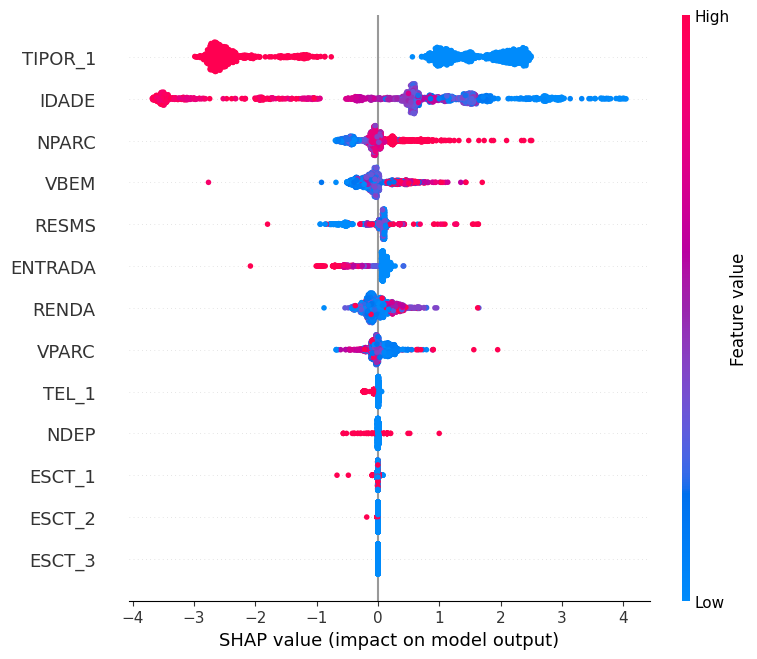

In [39]:
shap.summary_plot(shap_values, q1_X_train)

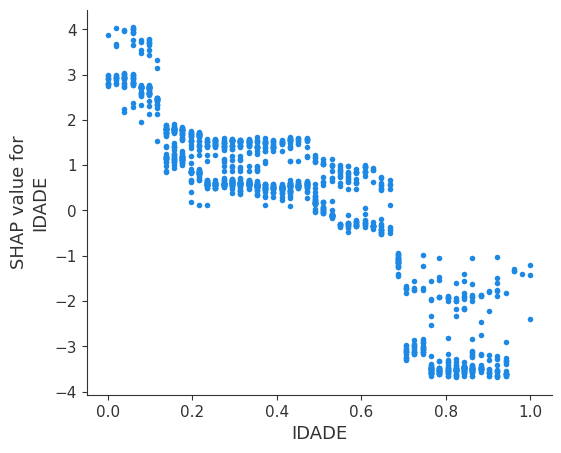

In [40]:
shap.dependence_plot("IDADE", shap_values, q1_X_train, interaction_index=None)